In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import ase
import glob
import tqdm
import time
import scipy
import numpy as np
import ase.io as aio
import pandas as pd
import skimage

from toolz.curried import pipe, curry, compose

In [3]:
import plot
import atommks.atomstat as astat
import atommks.helpers as utils

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['lines.color'] = 'r'
plt.style.use('ggplot')
scl = 2
mpl.rcParams['figure.figsize'] = [4.0*scl, 3.0*scl]
mpl.rcParams['figure.dpi'] = 80
mpl.rcParams['savefig.dpi'] = 100

mpl.rcParams['font.size'] = 9
mpl.rcParams['legend.fontsize'] = 'large'
mpl.rcParams['figure.titlesize'] = 'medium'


def compute_pca(x_data, n_comp=10, vis=True, labels=None, tag=""):
    from sklearn.decomposition import PCA
    pca = PCA(n_components=n_comp)
    scores = pca.fit_transform(x_data)

    if vis:
        ex_var = pca.explained_variance_ratio_ * 100
        plt.bar(np.arange(1, n_comp+1), ex_var)
        plt.ylim([0, 100])
        for ix, item in enumerate(ex_var):
            plt.text(ix+0.5, item+1.0, "{:1.2f}".format(item))
        plt.title("Explained variance plot {}".format(tag))
        plt.grid(b=None)
        plt.show()
        

        if labels is None:
            labels = np.arange(1, len(scores)+1)
            
        plt.scatter(scores[:,0], scores[:,1], c=labels, s=labels)
        plt.xlabel("PC 1")
        plt.ylabel("PC 2")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
        plt.scatter(scores[:,1], scores[:,2], c=labels, s=labels)
        plt.xlabel("PC 2")
        plt.ylabel("PC 3")
        plt.grid(b=None)
        plt.title("PC space representation {}".format(tag))
        plt.show()
        
    return scores, pca

def plot_corrs_scatter(x, y, xlabel="", ylabel="", title="", xscale="linear", yscale="linear", corr=True):
    plt.plot(x, y, "*--r")
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(False)
    if corr:
        title = "{} correlation: {:1.3f}".format(title, 
                                                 np.corrcoef(x, y)[0,1]) 
    plt.title(title)
    plt.xscale(xscale)
    plt.yscale(yscale)
    plt.show()
    
def plot_corrs_bar(x, y, title=""):
    corrs = []
    N = x.shape[1]
    N = 5
    for ix in range(N):
        corrs.append(np.fabs(np.corrcoef(x[:,ix], y)[0,1]))
        
    plt.bar(np.arange(N), corrs)
    
    for ix, item in enumerate(corrs):
        plt.text(ix-0.25, 1.0 - 0.01 * ix, "{:1.2f}".format(item))
    
    plt.ylim([0.0, 1.1])
    plt.title(title)
    plt.grid(False)
    plt.show()
    
    
from ase import Atoms 
get_atoms = lambda a: Atoms(["Cu"]*len(a),
                            positions=a.get_positions(),
                            cell=a.get_cell(), 
                            pbc=[1, 1, 1], 
                            tags=a.get_tags())

runs = np.loadtxt("runs.txt").astype(int)

# SAED Analysis

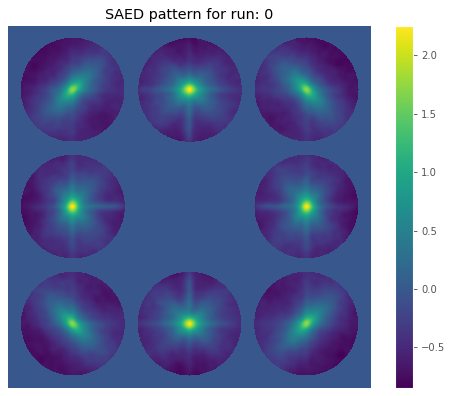

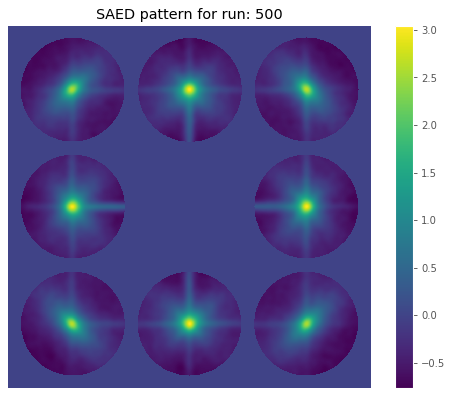

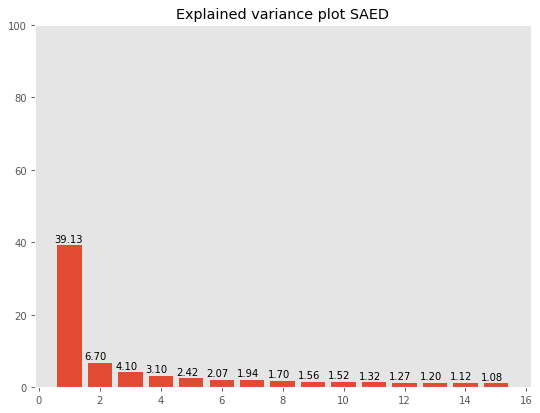

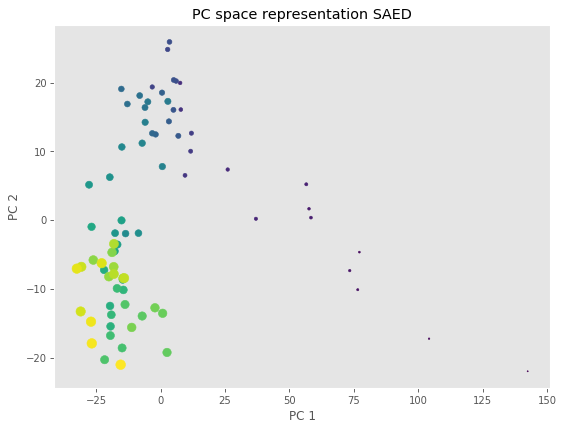

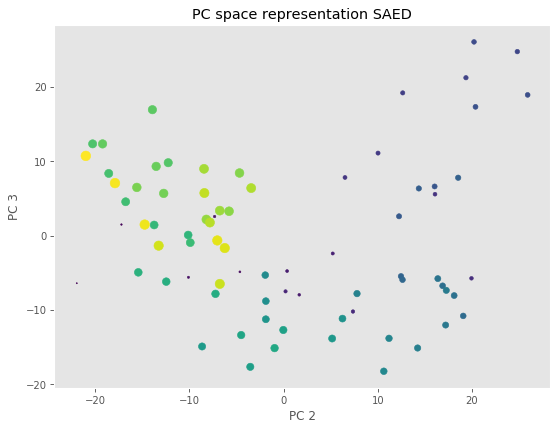

CPU times: user 1min 54s, sys: 8.18 s, total: 2min 2s
Wall time: 15.3 s


In [5]:
%%time
img_saed_h = pipe("data/saed_2048_masked_imgs_hid_blur_10.pkl", 
                  utils.load_file,
                  lambda lst: [np.ravel(x)[None] for x in lst], 
                  curry(np.concatenate)(axis=0))

plot.draw_2d(img_saed_h[0].reshape([1401, 1401]), "SAED pattern for run: {}".format(runs[0]))
plot.draw_2d(img_saed_h[1].reshape([1401, 1401]), "SAED pattern for run: {}".format(runs[1]))

scores_saed_h, pca_saed_h = compute_pca(img_saed_h[1:], n_comp=15, tag="SAED", labels=None)

In [6]:
peaks_1_sum = utils.load_file("peaks_1_max.pkl")
peaks_2_sum = utils.load_file("peaks_2_max.pkl")
saed_peak_1 = utils.load_file("peaks_1_arr.pkl")
saed_peak_2 = utils.load_file("peaks_2_arr.pkl")
peaks_all_sum = utils.load_file("peaks_sum.pkl")

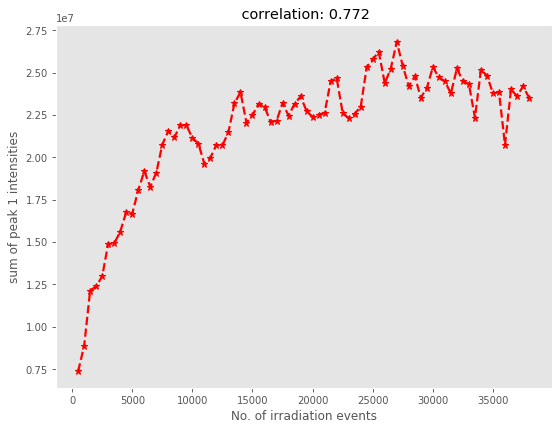

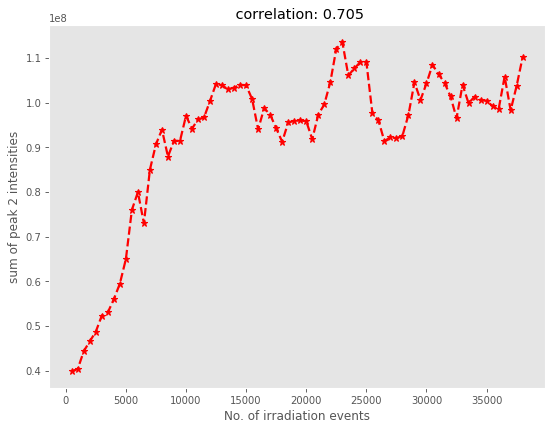

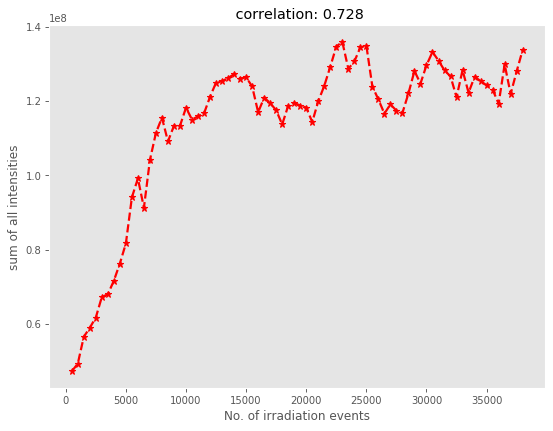

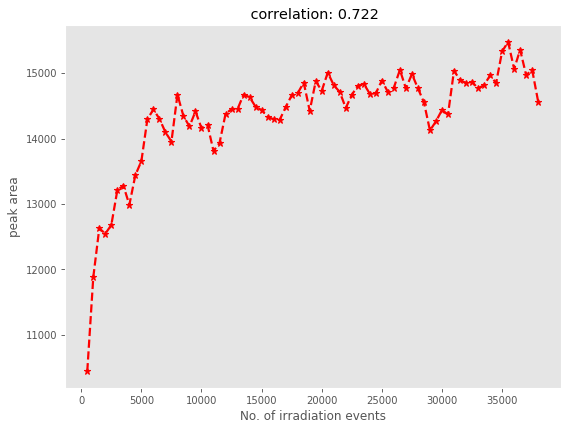

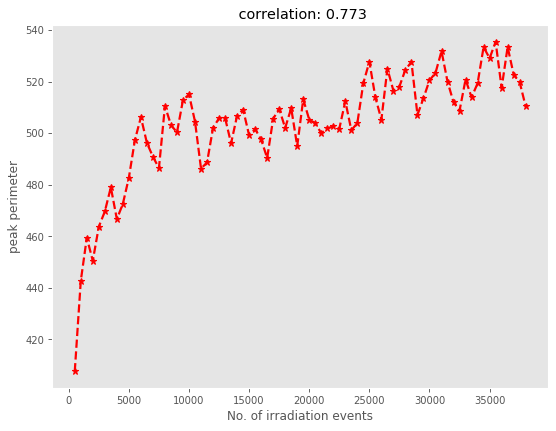

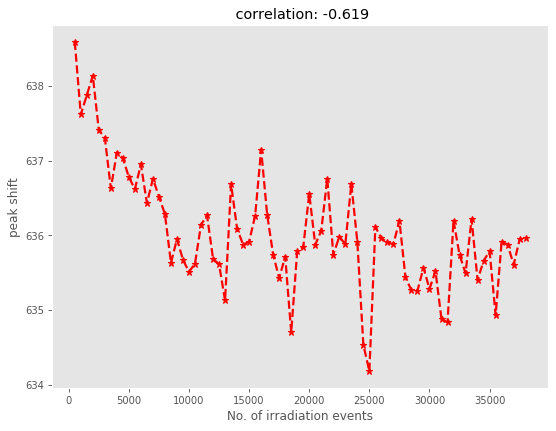

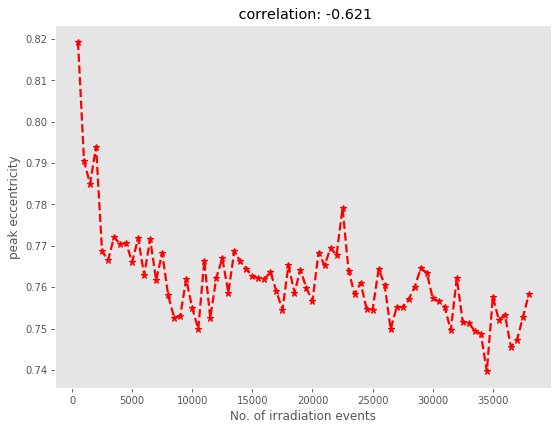

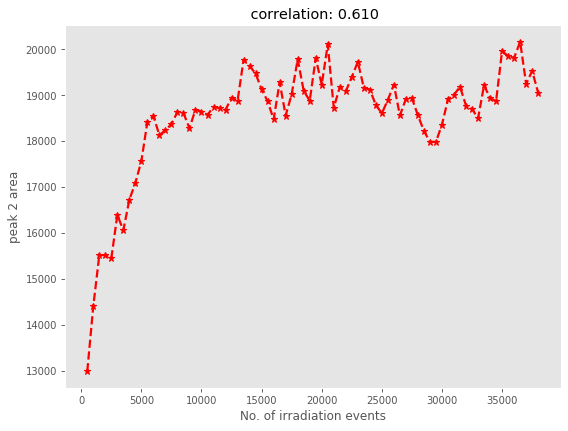

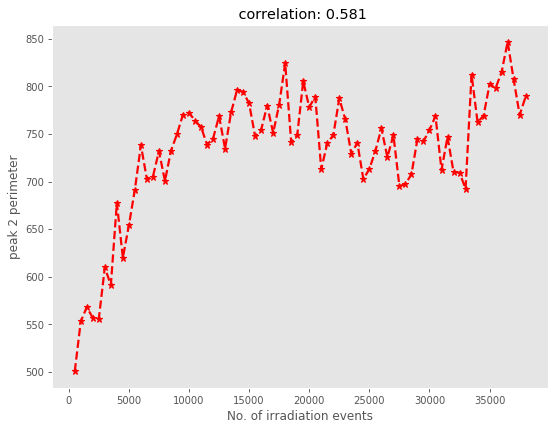

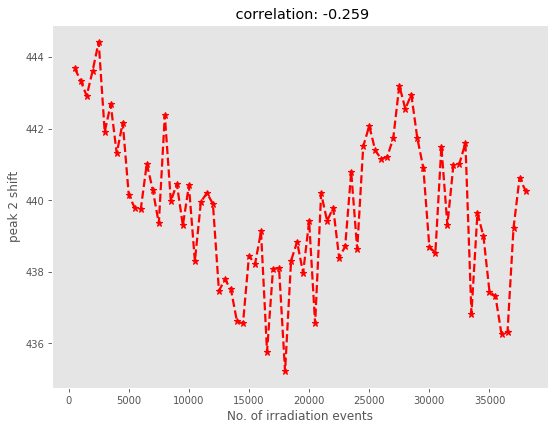

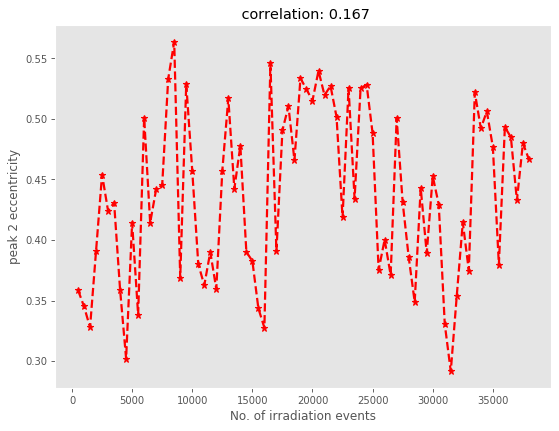

In [8]:
plot_corrs_scatter(runs[1:], peaks_1_sum.sum(axis=1)[1:], 
                   xlabel="No. of irradiation events", 
                   ylabel="sum of peak 1 intensities")

plot_corrs_scatter(runs[1:], peaks_2_sum.sum(axis=1)[1:], 
                   xlabel="No. of irradiation events", 
                   ylabel="sum of peak 2 intensities")

plot_corrs_scatter(runs[1:], peaks_all_sum[1:], 
                   xlabel="No. of irradiation events", 
                   ylabel="sum of all intensities")

plot_corrs_scatter(runs[1:], saed_peak_1[1:,0], xlabel="No. of irradiation events", ylabel="peak area")
plot_corrs_scatter(runs[1:], saed_peak_1[1:,1], xlabel="No. of irradiation events", ylabel="peak perimeter")
plot_corrs_scatter(runs[1:], saed_peak_1[1:,2], xlabel="No. of irradiation events", ylabel="peak shift")
plot_corrs_scatter(runs[1:], saed_peak_1[1:,3], xlabel="No. of irradiation events", ylabel="peak eccentricity")

plot_corrs_scatter(runs[1:], saed_peak_2[1:,0], xlabel="No. of irradiation events", ylabel="peak 2 area")
plot_corrs_scatter(runs[1:], saed_peak_2[1:,1], xlabel="No. of irradiation events", ylabel="peak 2 perimeter")
plot_corrs_scatter(runs[1:], saed_peak_2[1:,2], xlabel="No. of irradiation events", ylabel="peak 2 shift")
plot_corrs_scatter(runs[1:], saed_peak_2[1:,3], xlabel="No. of irradiation events", ylabel="peak 2 eccentricity")

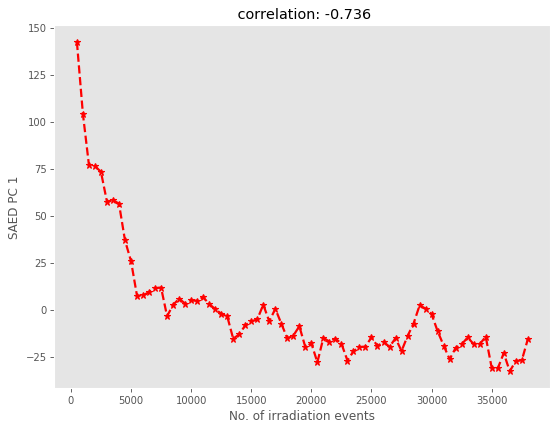

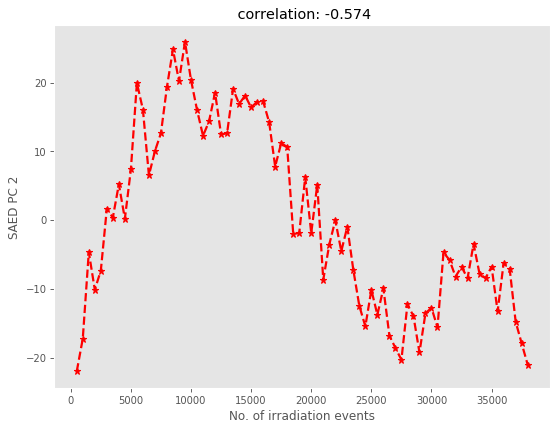

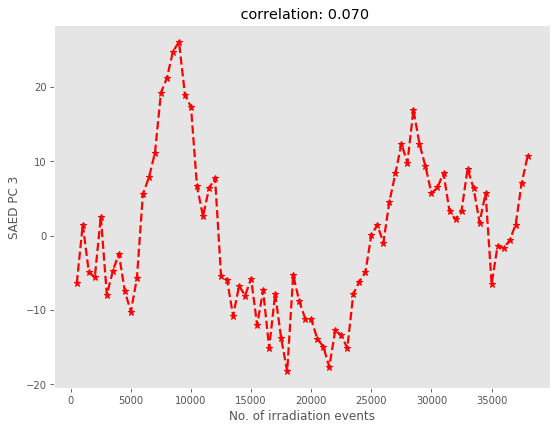

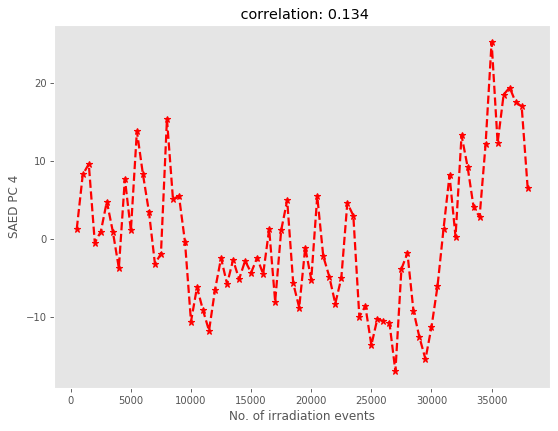

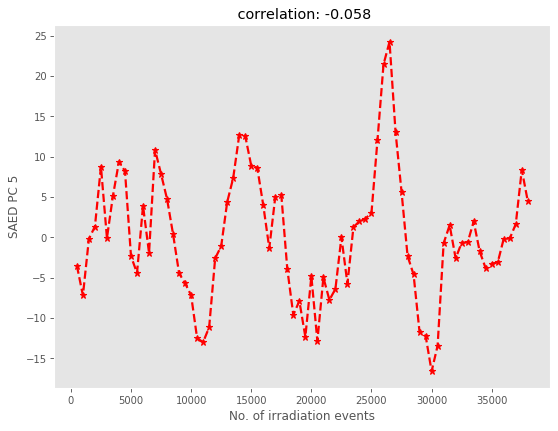

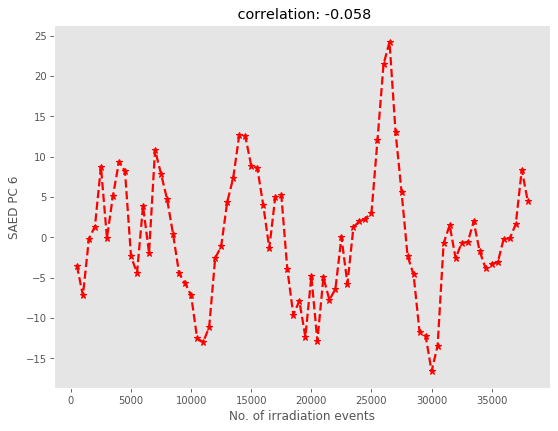

In [9]:
plot_corrs_scatter(runs[1:], scores_saed_h[:, 0], xlabel="No. of irradiation events", ylabel="SAED PC 1")
plot_corrs_scatter(runs[1:], scores_saed_h[:, 1], xlabel="No. of irradiation events", ylabel="SAED PC 2")
plot_corrs_scatter(runs[1:], scores_saed_h[:, 2], xlabel="No. of irradiation events", ylabel="SAED PC 3")
plot_corrs_scatter(runs[1:], scores_saed_h[:, 3], xlabel="No. of irradiation events", ylabel="SAED PC 4")
plot_corrs_scatter(runs[1:], scores_saed_h[:, 4], xlabel="No. of irradiation events", ylabel="SAED PC 5")
plot_corrs_scatter(runs[1:], scores_saed_h[:, 4], xlabel="No. of irradiation events", ylabel="SAED PC 6")

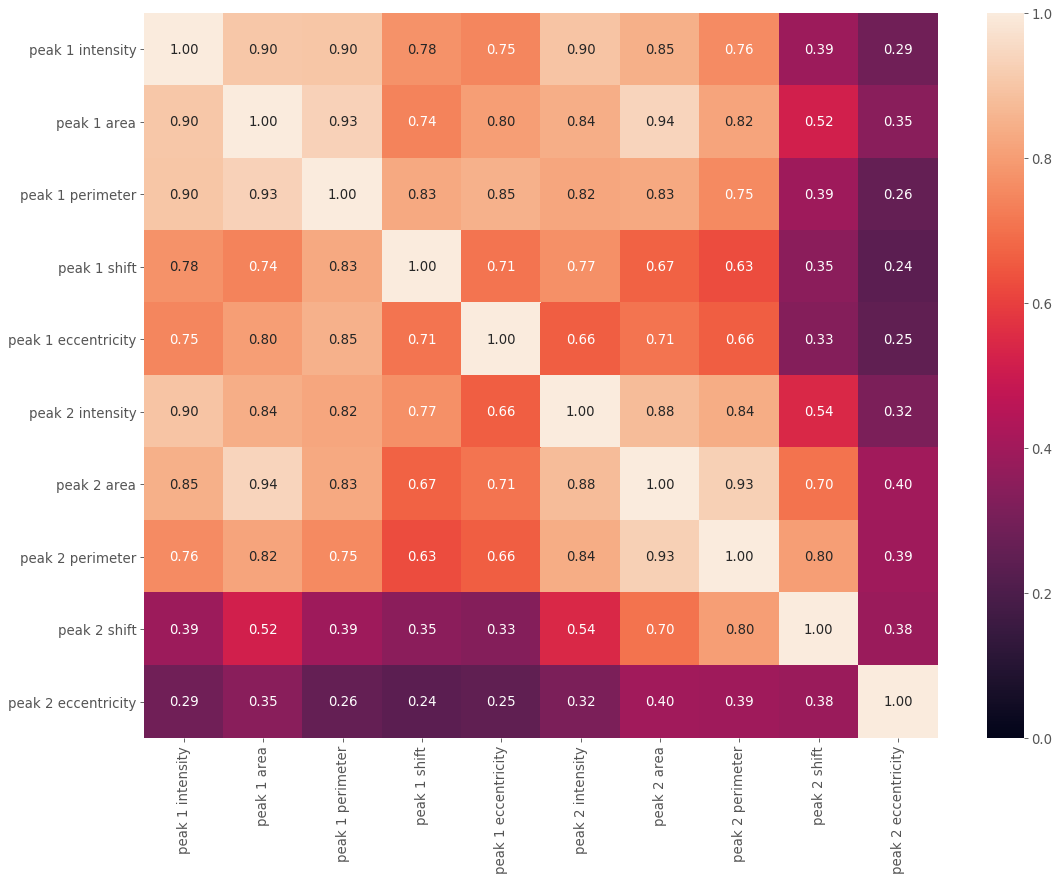

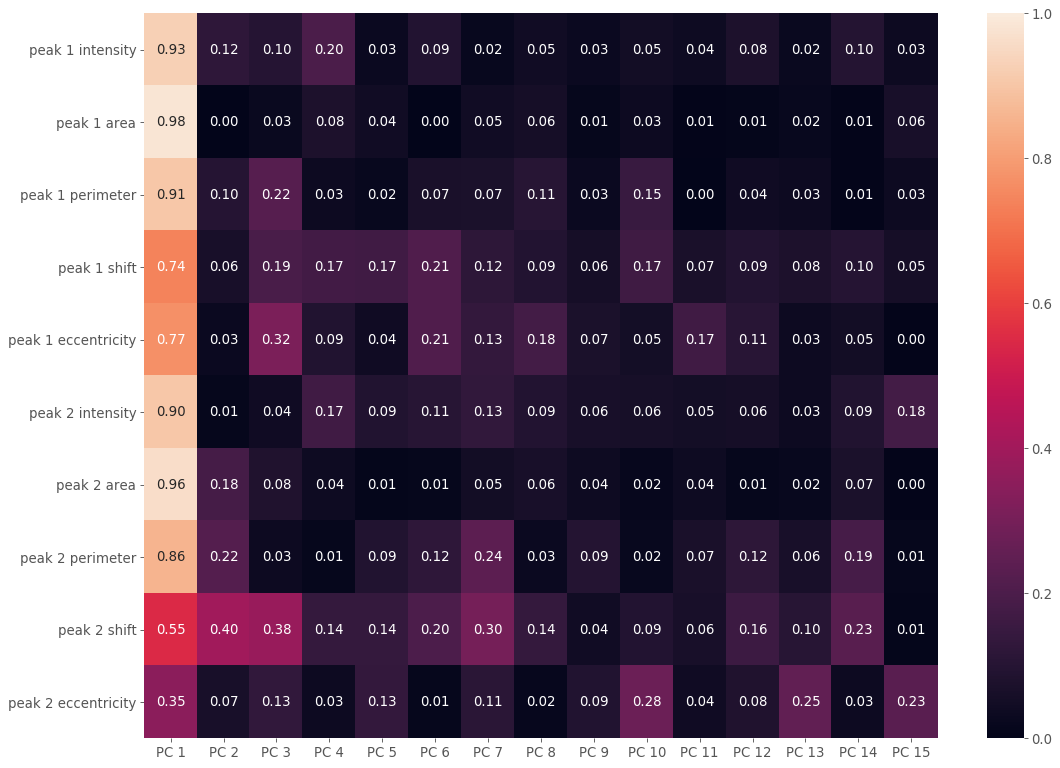

In [11]:
y_lbl_pca = ["PC {}".format(i+1) for i in range(15)]
y_lbl_pks = ["peak 1 intensity", "peak 1 area", "peak 1 perimeter", "peak 1 shift", "peak 1 eccentricity", 
             "peak 2 intensity", "peak 2 area", "peak 2 perimeter", "peak 2 shift", "peak 2 eccentricity"]

df_pks = pd.DataFrame(np.concatenate([peaks_1_sum.sum(axis=1)[1:,None], 
                                      saed_peak_1[1:,:-1], 
                                      peaks_2_sum.sum(axis=1)[1:,None], 
                                      saed_peak_2[1:,:-1]], 
                                     axis=1), 
                      columns=y_lbl_pks)

df_pca = pd.DataFrame(scores_saed_h, columns=y_lbl_pca)

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_pks.corr().abs(), annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0, 1.0)
plt.show()

corr_dct = {}
for lbl in y_lbl_pca:
      corr_dct[lbl] = df_pks.corrwith(df_pca[lbl])
        
df_corr = pd.DataFrame(corr_dct, index=y_lbl_pks).abs()

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

# Structure Analysis

In [83]:
@curry
def get_smooth_rdf(a, r_stat, width, len_pixel=1000, defects_only=True, verbose=True):
    
    import atommks_v1.atomstat as astat
    idx = np.where(a.get_tags() != 1)[0]
    
    if verbose:
        print("total atoms: {}, disturbed atoms: {}".format(len(a), len(idx)))
        
    if defects_only:
        coords_all = a.get_positions()[idx]
    else:
        coords_all = a.get_positions()
        
    coords_sub = a.get_positions()[idx]
    coords_stat = astat.get_realStats(coords_all, 
                                  coords_sub, 
                                  cell_dim=a.get_cell_lengths_and_angles(),
                                  cell=a.get_cell(), 
                                  pbc=a.get_pbc(),
                                  r_stat=r_stat,
                                  cutoff=r_stat+1.0,)
    rdf, pdf, bin_centers = astat.get_rdf(coords_stat, r_stat, len_pixel=len_pixel)
    kernel = utils.epanechnikov_kernel(width=width, x=bin_centers)
    return utils.convolve_kernel(kernel, pdf)

In [82]:
to_arr = lambda L: np.concatenate([l[None] for l in L], axis=0)

r_stat = 10.0
width_rdf = 0.25
len_pixel=1000 

gen_rdfs_def = get_smooth_rdf(r_stat=r_stat, width=width_rdf, len_pixel=len_pixel, defects_only=True, verbose=False)
# gen_rdfs_all = get_smooth_rdf(r_stat=r_stat, width=width_rdf, len_pixel=len_pixel, defects_only=False, verbose=False)

ix = 1
atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(runs[ix]), 
     lambda f: utils.load_file(f), 
     lambda a: get_atoms(a))

strt = time.time()
rdf_def = gen_rdfs_def(atoms)
print("time elapsed in rdf computation (defects only): {:1.3f}s".format(time.time()-strt))

time elapsed in rdf computation (defects only): 33.225s


In [94]:
@curry
def generate_stats(run, folder_rdf="data/rdfs_def"):
    
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
         lambda f: utils.load_file(f), 
         lambda a: get_atoms(a))
    
    rdf_def = gen_rdfs_def(atoms)
    f_out = "{}/dump.arc.{}_stat.pkl".format(folder_rdf, run)
    utils.save_file(fname=f_out, obj=rdf_def)
    print(f_out)
    
%%time
import multiprocessing as mp
n_proc = 12
with mp.Pool(n_proc) as p:
    p.map(generate_stats(folder_rdf="data/rdfs_def"), runs[1:])

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


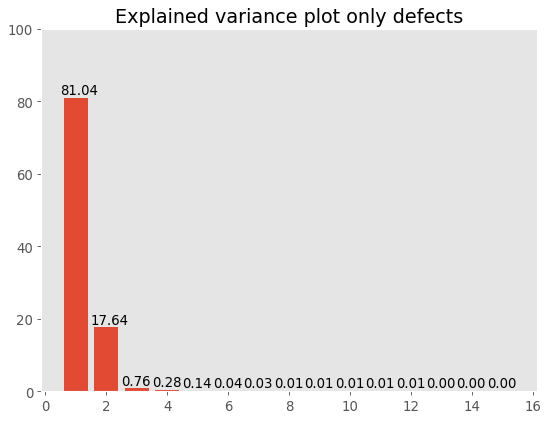

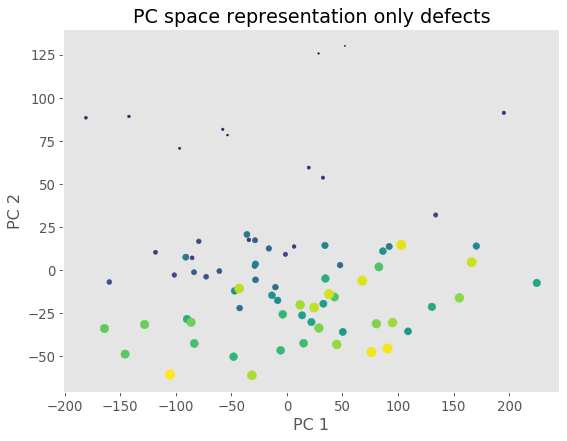

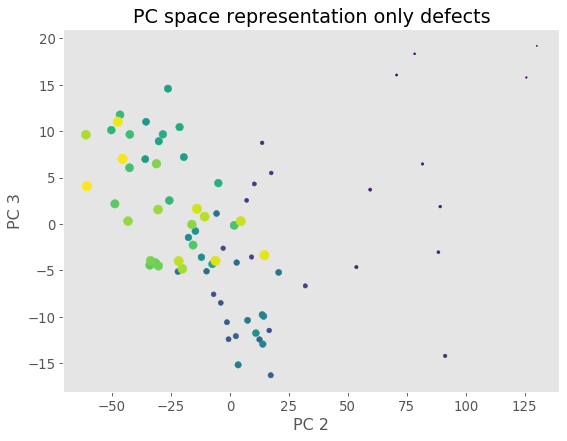

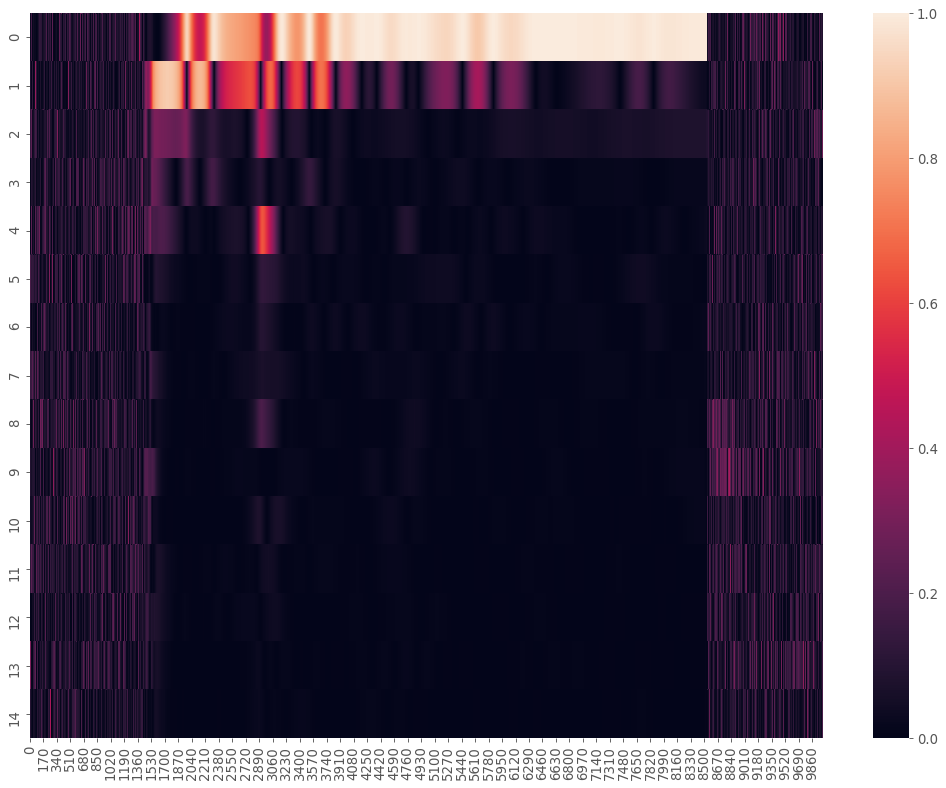

In [109]:
# %%time
# import multiprocessing as mp
# n_proc = 12
# with mp.Pool(n_proc) as p:
#     p.map(generate_stats(folder_rdf="data/rdfs_def"), runs[1:])

rdf_list_def = []
for run in tqdm.tqdm_notebook(runs[1:]):

    f_stat_def = "data/rdfs_def/dump.arc.{}_stat.pkl".format(run)
    stat_def = utils.load_file(f_stat_def)
    rdf_list_def.append(stat_def[None])
rdfs_def = np.concatenate(rdf_list_def, axis=0)[1:]

n_features = rdfs_def.shape[1]
n_comp = 15

scores_rdf_def, pca_rdf_def = compute_pca(rdfs_def, n_comp=n_comp, tag="only defects", labels=None)

corr_pca_def = np.zeros((n_features, 15))
for i0 in range(n_features):
    for i1 in range(n_comp):
        corr_pca_def[i0, i1] = np.fabs(np.corrcoef(rdfs_def[:,i0], scores_rdf_def[:,i1])[0,1])

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_def.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

In [ ]:
corr_pca_def = np.zeros((1500, 15))

for i0 in range(1500):
    for i1 in range(15):
        corr_pca_irr[i0, i1] = np.fabs(np.corrcoef(rdfs_irr[:,i0], scores_rdf_irr[:,i1])[0,1])
        corr_pca_all[i0, i1] = np.fabs(np.corrcoef(rdfs_all[:,i0], scores_rdf_all[:,i1])[0,1])

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_all.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_irr.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

In [19]:
smooth_sig = curry(lambda sig, w, bins: utils.convolve_kernel(kernel_arr=utils.epanechnikov_kernel(width=w, 
                                                                                                 x=bins), 
                                                          sig=sig))(w=width_rdf)
rdf_list_irr = []
rdf_list_all = []

for run in tqdm.tqdm_notebook(runs):

    f_stat_irr = "data/stats_new_irr/dump.arc.{}_stat.pkl".format(run)
    stat_irr = utils.load_file(f_stat_irr)
    
    f_stat_all = "data/stats_new/dump.arc.{}_stat.pkl".format(run)
    stat_all = utils.load_file(f_stat_all)
    
    rdf_list_irr.append(smooth_sig(bins=stat_irr["bins"])(stat_irr["pdf"])[None])
    rdf_list_all.append(smooth_sig(bins=stat_all["bins"])(stat_all["pdf"])[None])
    
rdfs_irr = np.concatenate(rdf_list_irr, axis=0)[1:]
rdfs_all = np.concatenate(rdf_list_all, axis=0)[1:]

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


In [ ]:
corrs_irr = []
corrs_all = []
for ix in range(1500):
    corrs_irr.append(np.fabs(np.corrcoef(rdfs_irr[:,ix], n_atoms_irr)[0,1]))

    corrs_all.append(np.fabs(np.corrcoef(rdfs_all[:,ix], n_atoms_irr)[0,1]))
    
plt.plot(corrs_irr, "--*")
plt.show()

plt.plot(corrs_all, "--*")
plt.show()

corrs_irr = []
corrs_all = []
for ix in range(1500):
    corrs_irr.append(np.fabs(np.corrcoef(rdfs_irr[:,ix], n_atoms_irr)[0,1]))

    corrs_all.append(np.fabs(np.corrcoef(rdfs_all[:,ix], n_atoms_irr)[0,1]))
    
plt.plot(corrs_irr, "--*")
plt.show()

plt.plot(corrs_all, "--*")
plt.show()

scores_rdf_irr, pca_rdf_irr = compute_pca(rdfs_irr, n_comp=15, tag="only defects", labels=None)
scores_rdf_all, pca_rdf_irr = compute_pca(rdfs_all, n_comp=15, tag="all atoms", labels=None)

In [38]:
# # label using volume
# d = utils.load_file("data/grids/dump.arc.{}_grid.pkl".format(runs[1]))
# props = skimage.measure.regionprops(d["lbl"])

# d_lbl = d["lbl"]

# lbls = np.unique(d_lbl)
# vols = [p.area for p in props]

# d_vol = d_lbl.copy()
# for i0, lbl in enumerate(lbls[1:]):
#     d_vol[np.where(d_lbl==lbl)] = vols[i0]
    
# utils.write2vtk(matrix=d_vol, fname="zeo_vol.vtk")

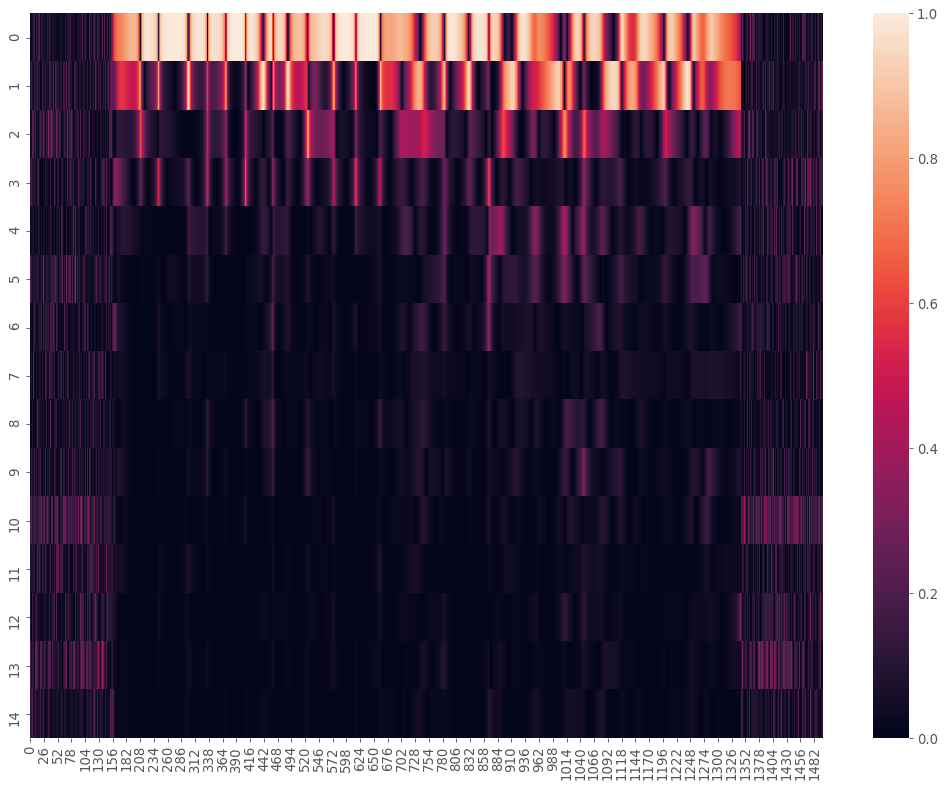

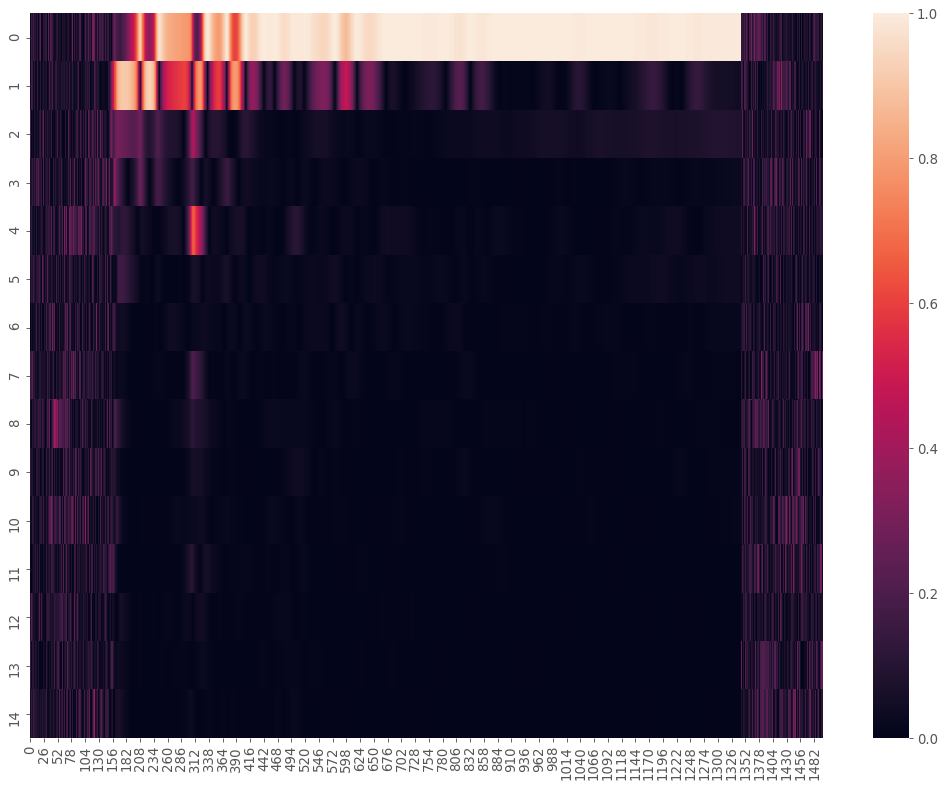

In [74]:
corr_pca_irr = np.zeros((1500, 15))
corr_pca_all = np.zeros((1500, 15))

for i0 in range(1500):
    for i1 in range(15):
        corr_pca_irr[i0, i1] = np.fabs(np.corrcoef(rdfs_irr[:,i0], scores_rdf_irr[:,i1])[0,1])
        corr_pca_all[i0, i1] = np.fabs(np.corrcoef(rdfs_all[:,i0], scores_rdf_all[:,i1])[0,1])

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_all.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(corr_pca_irr.T, annot=False, vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

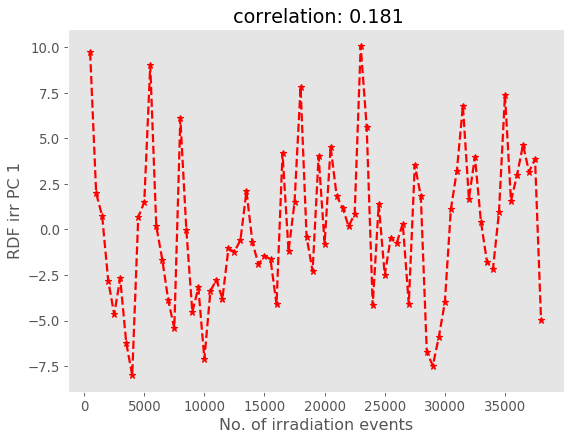

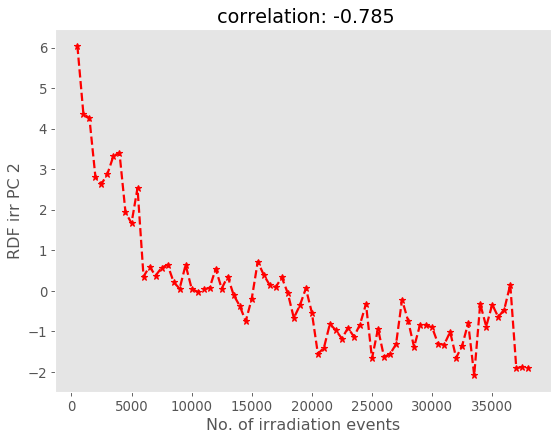

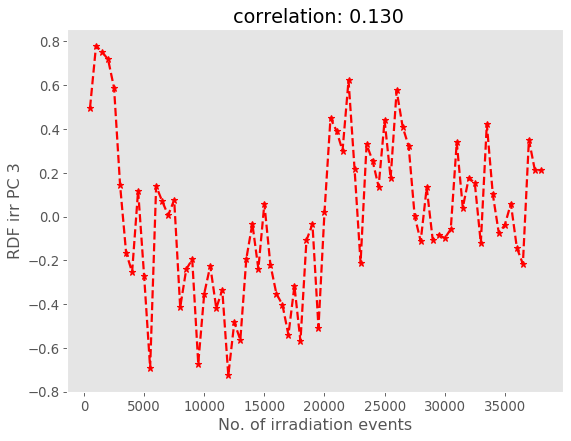

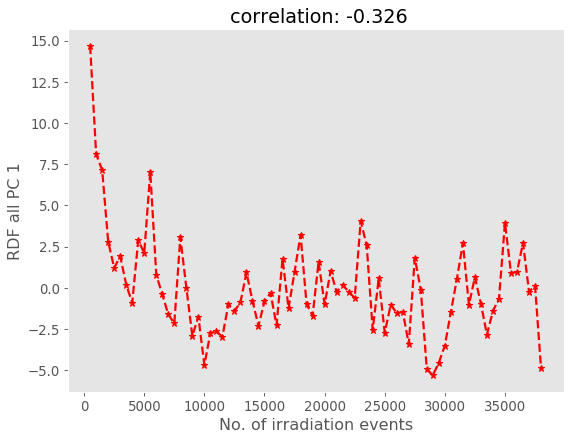

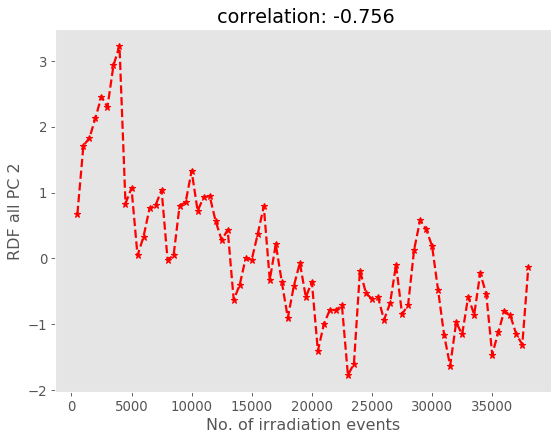

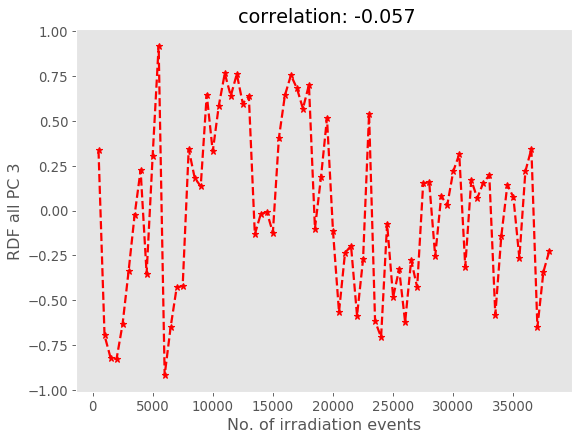

In [78]:
plot_corrs_scatter(runs[1:], scores_rdf_irr[:, 0], xlabel="No. of irradiation events", ylabel="RDF irr PC 1")
plot_corrs_scatter(runs[1:], scores_rdf_irr[:, 1], xlabel="No. of irradiation events", ylabel="RDF irr PC 2")
plot_corrs_scatter(runs[1:], scores_rdf_irr[:, 2], xlabel="No. of irradiation events", ylabel="RDF irr PC 3")

plot_corrs_scatter(runs[1:], scores_rdf_all[:, 0], xlabel="No. of irradiation events", ylabel="RDF all PC 1")
plot_corrs_scatter(runs[1:], scores_rdf_all[:, 1], xlabel="No. of irradiation events", ylabel="RDF all PC 2")
plot_corrs_scatter(runs[1:], scores_rdf_all[:, 2], xlabel="No. of irradiation events", ylabel="RDF all PC 3")

In [42]:
from sklearn.decomposition import PCA

n_atoms_irr = []

n_x = []
n_y = []
n_z = []

v_tot = []
v_mean = []
v_std = []
n_clstr = []
m_x = []
m_y = []
m_z = []

nn_1mean = []
nn_1std = []

nn_2mean = []
nn_2std = []

nn_5mean = []
nn_5std = []

for run in tqdm.tqdm_notebook(runs[1:]):

    d = utils.load_file("data/grids/dump.arc.{}_grid.pkl".format(run))
    props = skimage.measure.regionprops(d["lbl"])

    n_cluster = len(props)
    vols = [prop.area for prop in props]
    centroids = np.concatenate([np.array(prop.centroid)[None] for prop in props], axis=0)
    
    tree = scipy.spatial.cKDTree(centroids)
    dlist = [tree.query(cx, 2)[0][1] for cx in centroids]
    nn_1mean.append(np.mean(dlist))
    nn_1std.append(np.std(dlist))
    
    dlist = [tree.query(cx, 3)[0][-1] for cx in centroids]
    nn_2mean.append(np.mean(dlist))
    nn_2std.append(np.std(dlist))
    
    dlist = [tree.query(cx, 6)[0][-1] for cx in centroids]
    nn_5mean.append(np.mean(dlist))
    nn_5std.append(np.std(dlist))
    
    moments = scipy.stats.moment(centroids, 2, 0)
    
    v_tot.append(np.sum(vols))
    v_mean.append(np.mean(vols))
    v_std.append(np.std(vols))
    n_clstr.append(len(props))
    m_x.append(moments[0])
    m_y.append(moments[1])
    m_z.append(moments[2])
    
    atoms = pipe("data/structs/dump.arc.{}_atom.pkl".format(run), 
         lambda f: utils.load_file(f), 
         lambda a: get_atoms(a))

    idx = np.where(atoms.get_tags() != 1)[0]
#     print("total atoms: {}, disturbed atoms: {}".format(len(atoms), len(idx)))
    
    if len(idx) == 0:
        np.random.seed(81396)
        idx = np.random.randint(low=0, high=len(atoms), size=10000)

    coords_all = atoms.get_positions()
    coords_sub = coords_all[idx]
    
    
    pca = PCA(n_components=3)
    scores = pca.fit_transform(coords_sub)
    moments = scipy.stats.moment(scores, 2, 0)
    
    n_x.append(moments[0])
    n_y.append(moments[1])
    n_z.append(moments[2])
    
    n_atoms_irr.append(len(idx))
    
    
# Load arc_dpa data
with open("../new-data/200629CK_Cu_ACC_Analysis/kr_arc_dpa.txt", "r") as f:
    lines = f.readlines()
n_atoms_dpa = []
for run in runs[1:]:
    n_atoms_dpa.append(int(lines[run].split()[-2]))

/storage/home/hhive1/ashanker9/data/anaconda3/envs/poremks/lib/python3.7/site-packages/ipykernel_launcher.py:26: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


In [41]:
x_lbl = ["Point Defect Cnts", 
         "Defect Clstr Cnts", 
         "Mean Clstr Vlm", 
         "Std of Clstr Vlm", 
         "1st NN  dist", 
         "2nd NN dist", 
         "5th NN dist"]

gen_arr = lambda x: np.asarray(x)[:,None]
df_x = pd.DataFrame(np.concatenate([gen_arr(n_atoms_irr), gen_arr(n_clstr), 
                gen_arr(v_mean), gen_arr(v_std), 
                gen_arr(nn_1mean), gen_arr(nn_2mean), 
                gen_arr(nn_5mean)], axis=1), columns=x_lbl)

corr_dct = {}
for lbl in x_lbl:
    corr_dct[lbl] = df_pks.corrwith(df_x[lbl])
        
df_corr = pd.DataFrame(corr_dct).abs()

plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
plt.show()

corr_dct = {}
for lbl in x_lbl:
    corr_dct[lbl] = df_pca.corrwith(df_x[lbl])
        
df_corr = pd.DataFrame(corr_dct).abs()


plt.figure(figsize=(16,12))
plt.rcParams.update({'font.size': 12})
g = sns.heatmap(df_corr, annot=True, fmt=".2f", vmin=0, vmax=1.0)
g.collections[0].colorbar.ax.set_ylim(0.0,1.0)
plt.show()

NameError: name 'n_atoms_irr' is not defined

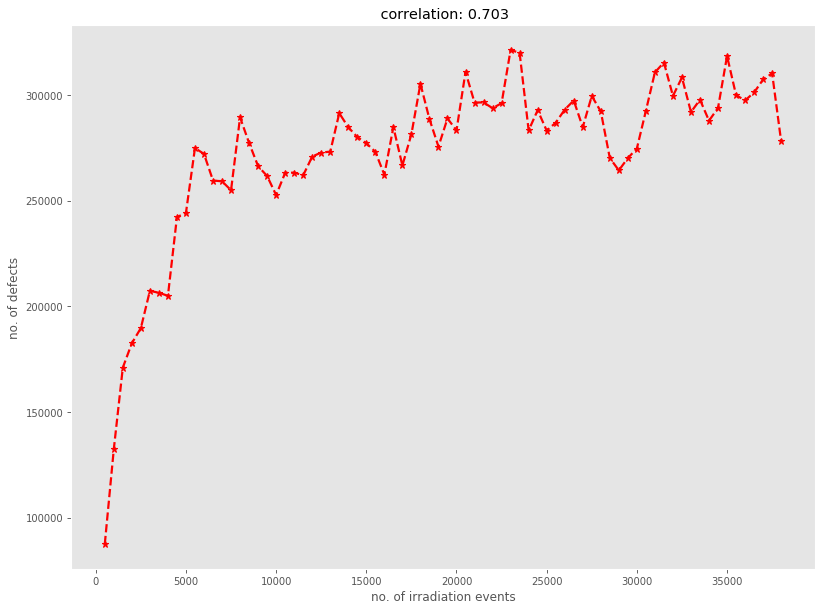

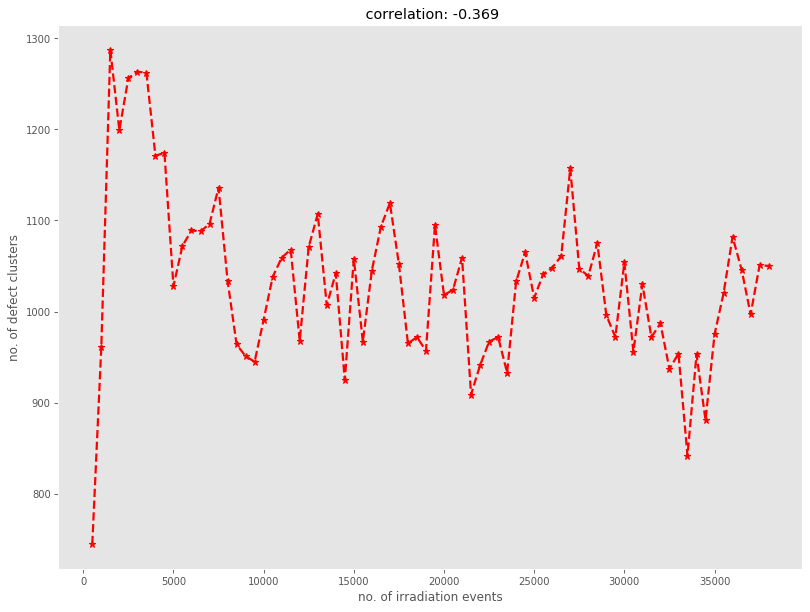

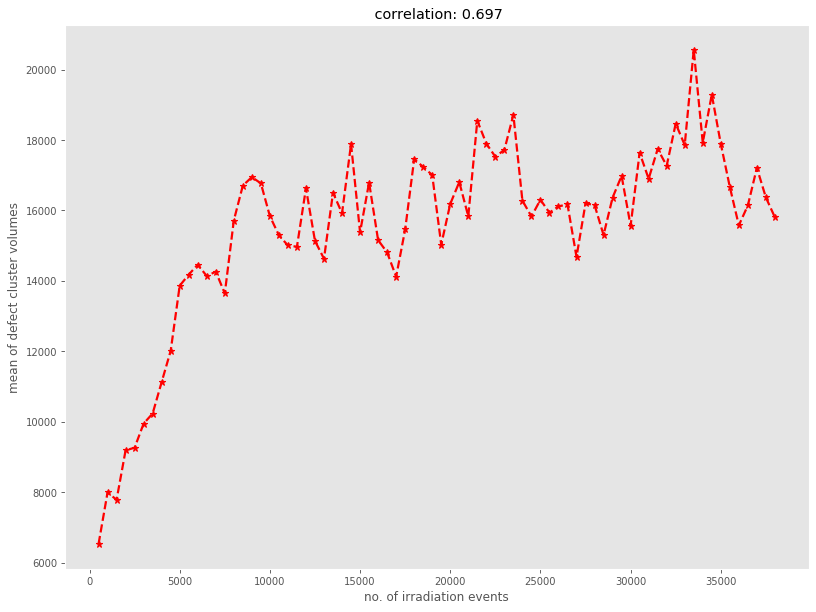

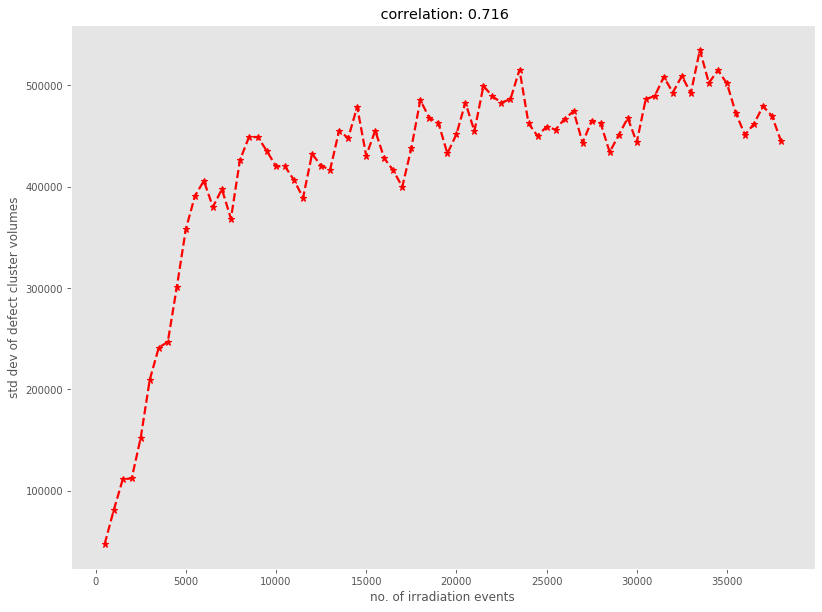

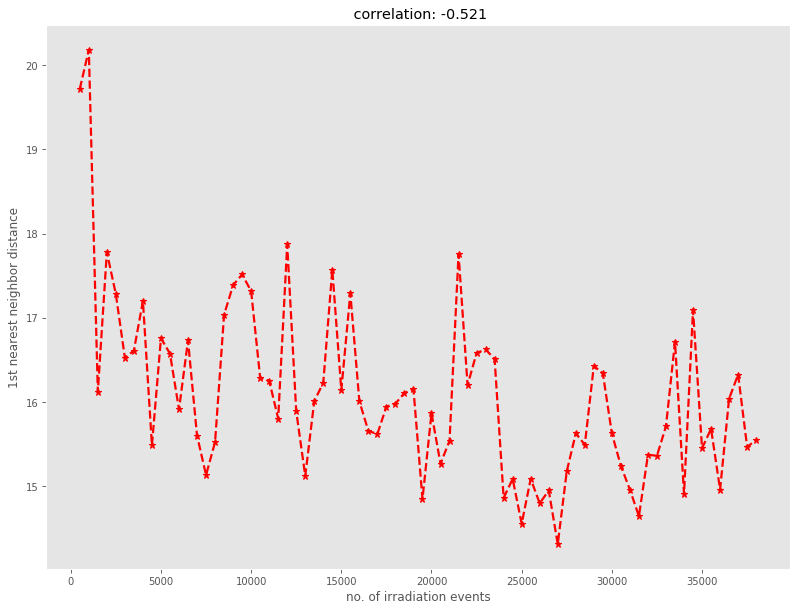

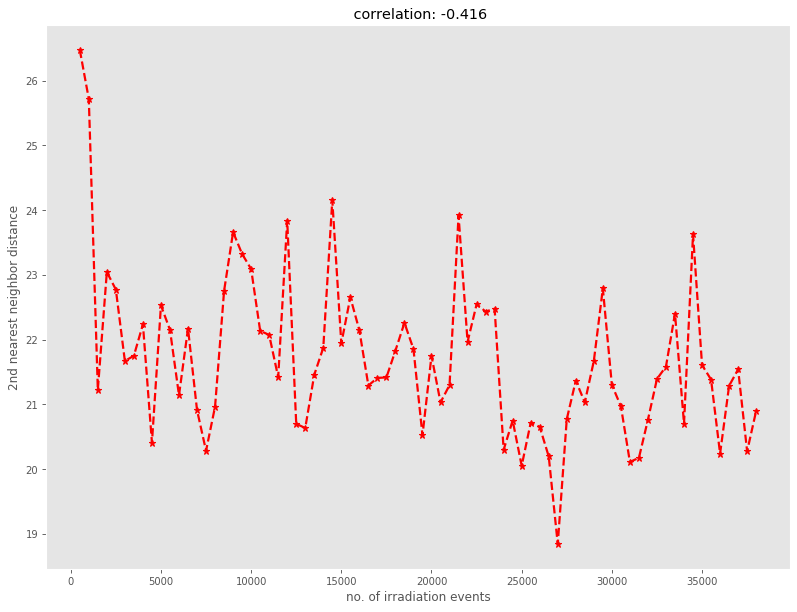

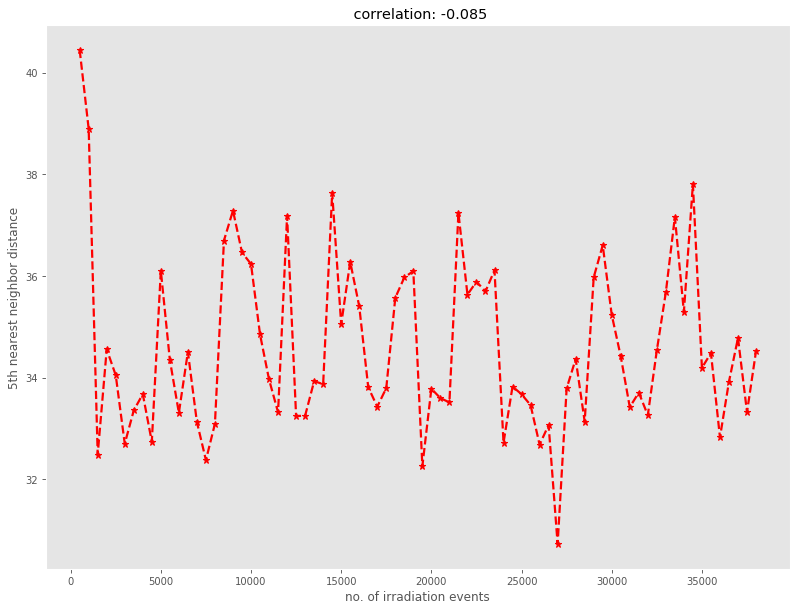

In [52]:
plot_corrs_scatter(runs[1:], n_atoms_irr, xlabel="no. of irradiation events", ylabel="no. of defects")
plot_corrs_scatter(runs[1:], n_clstr, xlabel="no. of irradiation events", ylabel="no. of defect clusters")
plot_corrs_scatter(runs[1:], v_mean, xlabel="no. of irradiation events", ylabel="mean of defect cluster volumes")
plot_corrs_scatter(runs[1:], v_std, xlabel="no. of irradiation events", ylabel="std dev of defect cluster volumes")
plot_corrs_scatter(runs[1:], nn_1mean, xlabel="no. of irradiation events", ylabel="1st nearest neighbor distance")
plot_corrs_scatter(runs[1:], nn_2mean, xlabel="no. of irradiation events", ylabel="2nd nearest neighbor distance")
plot_corrs_scatter(runs[1:], nn_5mean, xlabel="no. of irradiation events", ylabel="5th nearest neighbor distance")

In [161]:
import GPy
from sklearn.decomposition import PCA
from sklearn.model_selection import RepeatedKFold, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Ridge, BayesianRidge

In [278]:
maerror = lambda y1, y2: np.mean(np.fabs(y1-y2))

get_rbf_kernel = curry(lambda dim, var, scl, ard: GPy.kern.RBF(input_dim=dim, 
                                                    variance=var, 
                                                    lengthscale=scl, 
                                                    ARD=ard))

@curry
def gpr_trn(x_data, y_data, scl=1.0, var=1.0, ard=True):
    
    if type(scl) is not list:
        scl = [scl] * x_data.shape[1] if ard else scl
    
    kernel = get_rbf_kernel(dim=x_data.shape[1], var=var, scl=scl, ard=ard)
    
    model = GPy.models.GPRegression(x_data, y_data, kernel)
    model.optimize();
    return model, kernel


@curry
def gpr_prd(x_data, model):
    y_prd, y_var = model.predict(x_data)
    return y_prd, np.sqrt(y_var)


@curry
def get_pca(x_data, n_comp):
    pca = PCA(n_components=n_comp)
    f_data = pca.fit(x_data)
    return pca


def get_smooth_rdf(width):
    
    rdfs = np.load("rdfs/rdf_spiky_7_200_.npy")
    
    if width > 0.0:
        bins = np.linspace(0, 7.0, rdfs.shape[1]+1)
        bin_centers = (bins[1:] + bins[:-1]) * 0.5
        kernel = epanechnikov_kernel(width=width, x=bin_centers)
        rdfs_smooth = convolve_kernel(kernel, rdfs)
        return rdfs_smooth
    else:
        return rdfs
    

@curry
def gpr_model_full(X_data, y_data, n_splits=5, n_repeats=10, seed=2652124, scl=None, var=None):

    X = X_data.copy()
    y = y_data.copy()

    rkf = RepeatedKFold(n_splits=n_splits, 
                        n_repeats=n_repeats, 
                        random_state=seed)
    
    generator = rkf.split(X)

    errs_mae = []
    errs_gpr = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        pca = get_pca(X_trn, n_comp=15)

        transformer_x = lambda x: pca.transform(x)
        transformer_y = lambda y: y

        x_inp = transformer_x(X_trn)
        y_inp = transformer_y(y_trn)
        
        if var is None:
            var = np.var(y_inp)
            
        if scl is None:
            scl = list(np.sqrt(pca.explained_variance_))
        
        try:
            gpr, rbf = gpr_trn(x_inp, y_inp, 
                               scl=scl, 
                               var=var, 
                               ard=True)

            y_prd_m, y_prd_s = gpr_prd(transformer_x(X_tst), 
                                       gpr)

            errs_mae.append(maerror(y_prd_m, y_tst))
        except Exception as err:
            print(err)
        
    return errs_mae, errs_gpr

def get_model(X, y, model, verbose=True):
    rkf = RepeatedKFold(n_splits=5, n_repeats=10, random_state=2652124)
    generator = rkf.split(X)

    errs_mae = []

    for ix, (trn_indx, tst_indx) in enumerate(generator):

        X_trn, X_tst = X[trn_indx], X[tst_indx]
        y_trn, y_tst = y[trn_indx], y[tst_indx]

        model.fit(X_trn, y_trn)

        y_prd_m = model.predict(X_tst)

        y_prd_m_ = model.predict(X_trn)

        errs_mae.append(maerror(y_prd_m, y_tst))
    
    if verbose:
        print("test set mae: mean:{:1.5f}, std:{:1.5f}".format(np.mean(errs_mae), np.std(errs_mae)))
        print("Normalized mae: {:1.5f}".format(np.mean(errs_mae)/np.mean(y)))        
    return errs_mae

In [164]:
#     lims = [min(y), max(y)]
#     plt.plot(y_trn, y_prd_m_, "r*")
#     plt.plot(y_tst, y_prd_m, "g*")
#     plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

#     plt.tight_layout()
#     plt.grid(False)
#     plt.show()

In [228]:
X_peak = np.concatenate([saed_peak_1[1:, :-1], np.log10(np.asarray(saed_sum[1:])[...,None])], axis=1)
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
X_pca = pca.fit_transform(img_saed_h[1:])

In [238]:
X_peak = saed_peak_1[1:, :-1]
X_peak.shape

(76, 4)

test set mae: mean:1.40601, std:0.24403
Normalized mae: 0.04064
test set mae: mean:1.41289, std:0.23020
Normalized mae: 0.04084
test set mae: mean:1.43408, std:0.22651
Normalized mae: 0.04145
test set mae: mean:1.43137, std:0.22412
Normalized mae: 0.04137
test set mae: mean:1.39335, std:0.22336
Normalized mae: 0.04027


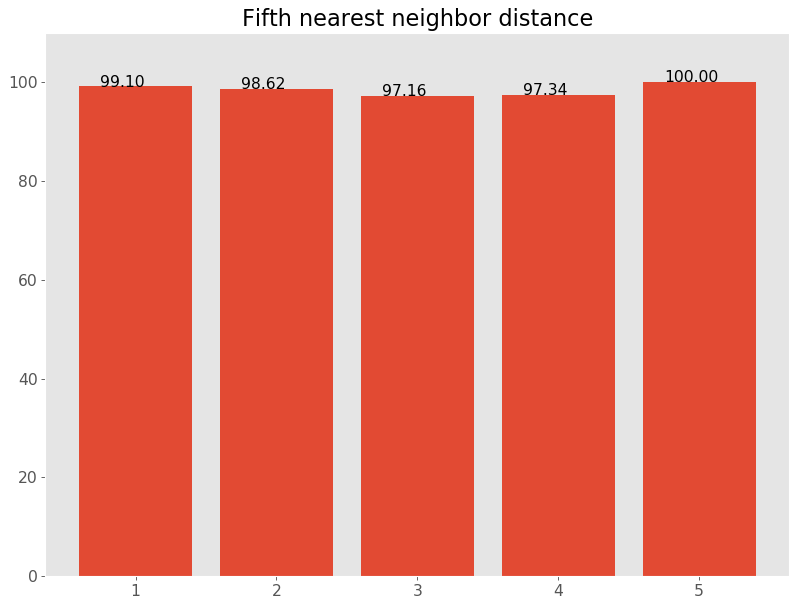

In [240]:
x = X_peak.copy()
y = np.asarray(nn_5mean)[...,None]

err_mean = []
err_mean.append(np.mean(get_model(x, y, Ridge(alpha=1.0), verbose=True)))
for i0 in range(x.shape[1]):
    errs_mae = get_model(x[:,i0][...,None], y, Ridge(alpha=1.0), verbose=True)
    err_mean.append(np.mean(errs_mae))
    
err_mean = np.asarray(err_mean)
z = err_mean.min()/ err_mean*100


plt.bar(np.arange(1, x.shape[1]+2), z)
plt.ylim([0, 110])
for ix, item in enumerate(z):
    plt.text(ix+0.75, item, "{:1.2f}".format(item))
plt.grid(False)
plt.title("Fifth nearest neighbor distance")
plt.show()

In [262]:
saed_labels = ["peak area", "peak perimeter", "peak shift", "peak eccentricity",  "PC 1"]
y_labels = ["no. of defects", "mean defect cluster volume", "std dev of defect cluster volume", "1st nearest neighbor distance", "2nd nearest neighbor distance"]

In [265]:
X_peak = np.concatenate([saed_peak_1[1:, :-1], np.log10(np.asarray(saed_sum[1:])[...,None])], axis=1)
pca = PCA(n_components=5)
X = pca.fit_transform(img_saed_h[1:])
X_pca = pca.fit_transform(img_saed_h[1:])

In [296]:
arr = lambda x: np.array(x)[:,None]
y_features = np.concatenate([arr(item) for item in [n_atoms_irr, v_mean, v_std, nn_1mean, nn_2mean]], axis=1)

err_dict_peak = {}

for i0 in range(y_features.shape[1]):
    err_dict_peak[y_labels[i0]] = get_model(X_peak, y_features[:,i0][...,None], Ridge(alpha=10.0), verbose=True) / np.mean(y_features[:,i0][...,None])
    
    
err_dict_pca = {}

for i0 in range(y_features.shape[1]):
    err_dict_pca[y_labels[i0]] = get_model(X_pca, y_features[:,i0][...,None], Ridge(alpha=10.0), verbose=True) / np.mean(y_features[:,i0][...,None])

test set mae: mean:7857.22437, std:1507.39965
Normalized mae: 0.02881
test set mae: mean:1153.43175, std:185.39245
Normalized mae: 0.07445
test set mae: mean:31813.99988, std:6341.23816
Normalized mae: 0.07586
test set mae: mean:0.65323, std:0.11602
Normalized mae: 0.04058
test set mae: mean:0.88450, std:0.15499
Normalized mae: 0.04072
test set mae: mean:5737.62824, std:915.51464
Normalized mae: 0.02104
test set mae: mean:997.34261, std:180.16012
Normalized mae: 0.06437
test set mae: mean:24421.74356, std:5395.52780
Normalized mae: 0.05824
test set mae: mean:0.63609, std:0.11658
Normalized mae: 0.03952
test set mae: mean:0.85112, std:0.17299
Normalized mae: 0.03919


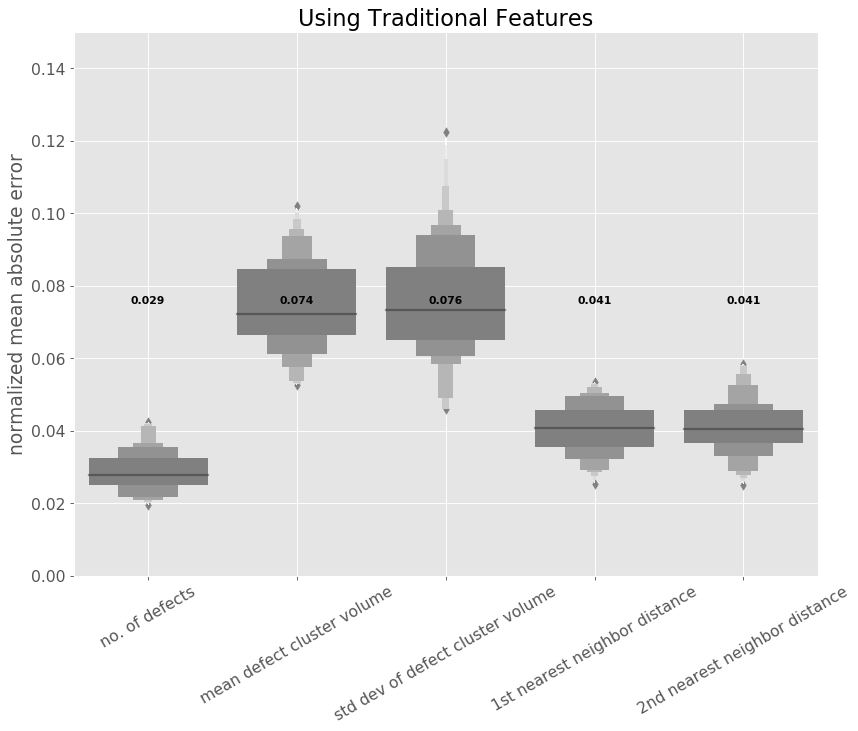

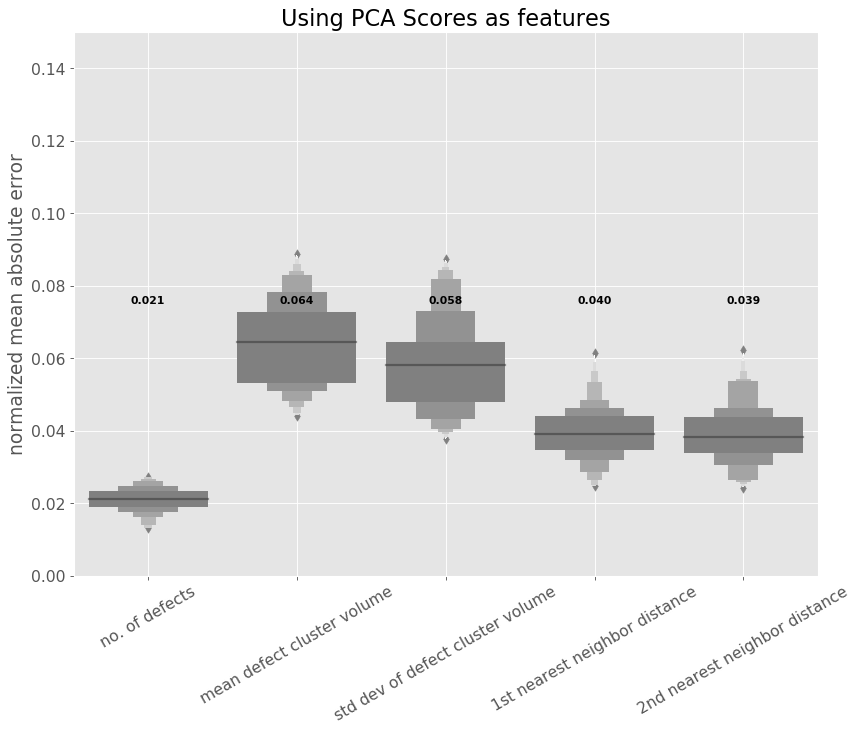

In [369]:
df_peak = pd.DataFrame(err_dict_peak)
df_pca = pd.DataFrame(err_dict_pca)

df_pca["label"] = ["pca"] * len(df_pca)
df_peak["label"] = ["peak"] * len(df_pca)

g = sns.boxenplot(data=df_peak, color='gray')
g.set_xticklabels(labels=y_labels,rotation=30)
plt.grid(True)
plt.title("Using Traditional Features")
plt.ylabel("normalized mean absolute error")
medians = df_peak.mean(axis=0)
for xtick in g.get_xticks():
    g.text(xtick, 0.075, "{:1.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
plt.ylim([0, 0.15])
plt.grid(True)
plt.show()

g = sns.boxenplot(data=df_pca, color='gray')
g.set_xticklabels(labels=y_labels,rotation=30)
plt.title("Using PCA Scores as features")
plt.ylabel("normalized mean absolute error")
medians = df_pca.mean(axis=0)
for xtick in g.get_xticks():
    g.text(xtick, 0.075, "{:1.3f}".format(medians[xtick]), 
            horizontalalignment='center',size='x-small',color='k',weight='semibold')
plt.ylim([0, 0.15])
plt.grid(True)
plt.show()

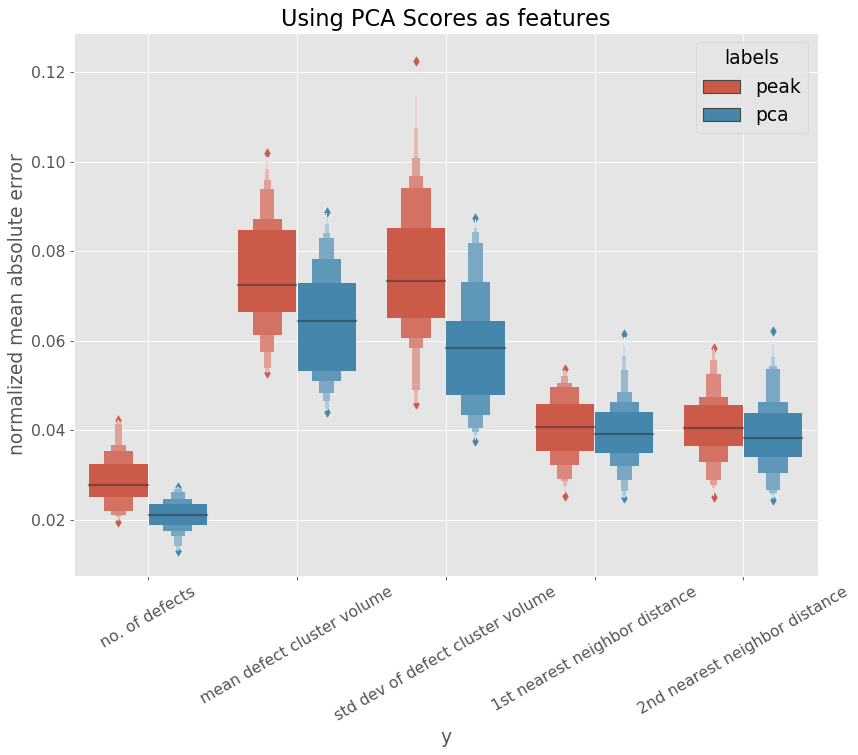

In [351]:
df = pd.DataFrame()
df_val = []
df_key = []

for k in err_dict_peak:
    df_val.append(err_dict_peak[k])
    df_key.append([k] * len(err_dict_peak[k]))
for k in err_dict_pca:
    df_val.append(err_dict_pca[k])
    df_key.append([k] * len(err_dict_pca[k]))
    
df["x"] = np.ravel(df_val)
df["y"] = np.ravel(df_key)
df["labels"] = ["peak"]*250 + ["pca"]*250

g = sns.boxenplot(y="x", x="y", hue="labels", data=df)
g.set_xticklabels(labels=y_labels,rotation=30)
plt.title("Using PCA Scores as features")
plt.ylabel("normalized mean absolute error")
plt.grid(True)
plt.show()